In [1]:
import drjit as dr
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from mitsuba import Float,Point2f 
from PDE2D import GreenSampling, Split
from PDE2D.utils.imageUtils import *

In [2]:
split = Split.Naive
green = GreenSampling.Polynomial
max_z = 4
use_accelaration = True
newton_steps = 5
weight_window = [0.5, 2]

In [3]:
rad = Float(1.0)
source_rad = Float(0.3)
source_val = Float(50.)
source_p = {}
source_p["radius"] = source_rad
source_p["val"] = source_val
def source_generator(params):
    def source(points):
        return dr.select(dr.norm(points) < params["radius"], params["val"], 0.0)
    return source


dirichlet_p = {}
dirichlet_p['freq'] = 2
dirichlet_p['bias'] = 1
def dirichlet_generator(params):
    def dirichlet(points):
         return dr.cos(params['freq'] * dr.atan2(points[0], points[1])) + params["bias"]
    return dirichlet

In [4]:
s = 1
bbox = [[-1.05 * rad * s, -1.05 * rad * s], [1.05 * rad * s, 1.05 * rad * s]]
resolution_image = [256, 256]
spp_image = 1024
epsilon = 1e-5
out_val = 1

image = np.array([[0,1,2,3,4],
                  [0,1,2,3,4],
                  [0,1,2,3,4],
                  [0,1,2,3,4],
                  [0,1,2,3,4]], dtype = np.float64)

image /= 2 
image += out_val
α = DiskTextureCoefficient("diffusion", image, radius = rad, constant_thickness= 0.05, origin = [0,0], out_val = out_val)
dirichlet = FunctionCoefficient("dirichlet", dirichlet_p, dirichlet_generator)
neumann = ConstantCoefficient("neumann",0)
σ = ConstantCoefficient("screening", 0)
f = FunctionCoefficient("source", source_p, source_generator)
shape = CircleShape(origin=Array2f(0., 0.), radius=rad, epsilon= epsilon,dirichlet=dirichlet)
data_holder = DataHolder(shape = shape, α = α, σ = σ, f=f)
print(data_holder.σ_bar)

NameError: name 'Array2f' is not defined

In [5]:
image, _ = data_holder.get_effective_screening()

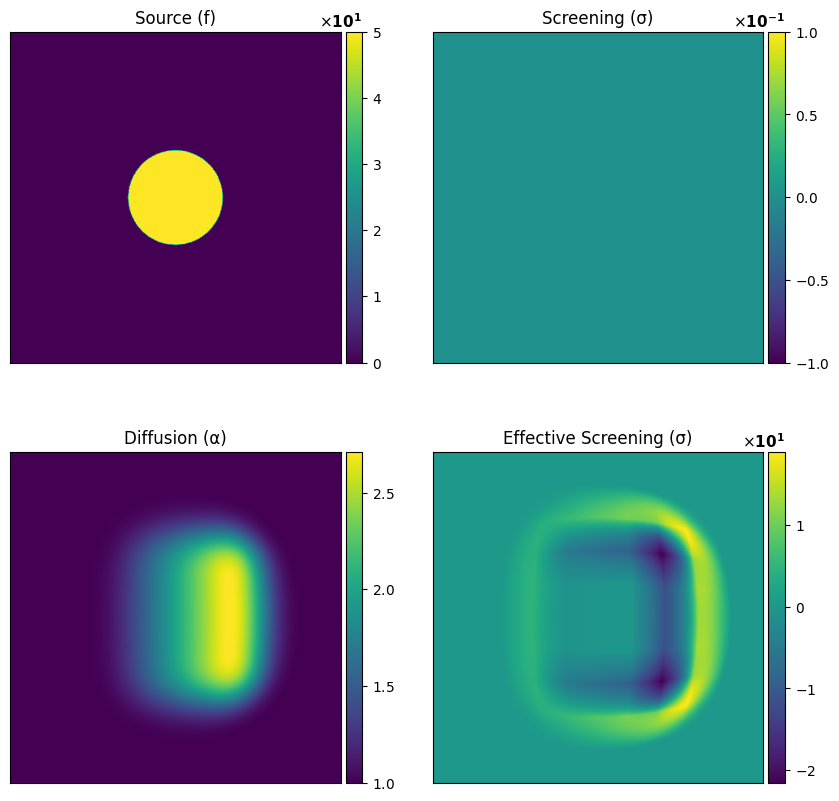

In [6]:
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize = (10,10))
data_holder.visualize(ax1, ax2, ax3, ax4)

In [7]:
wos_v = WosVariable(data_holder, seed = 21, green_sampling=green, max_z = max_z, newton_steps = newton_steps, use_accelaration=use_accelaration)
points = create_image_points(bbox, resolution_image, spp_image, centered = True)


In [8]:
L_v, _ = wos_v.solve(points_in = points, split = split)
image_v, tensor = create_image_from_result(L_v, resolution_image)

67108864 -> 0


Text(0.5, 1.0, 'Primal Solution')

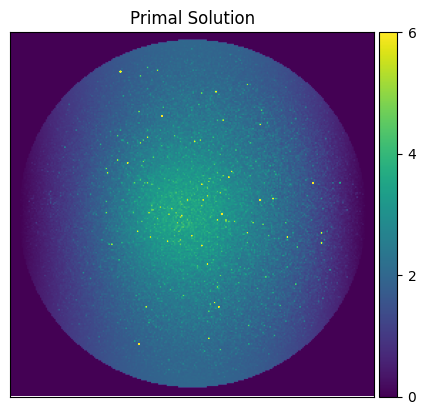

In [9]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
plot_image(image_v, ax, input_range =[0,6])
ax.set_title("Primal Solution")

In [10]:
rad_der = 0.9
res = 128
spp_der = 2 ** 20
fd_step = 5e-3
points = create_circle_points(radius = rad_der, resolution = res, spp = spp_der)
derivative_dir = points / dr.norm(points)
derivative_dir2 =Point2f(-derivative_dir[1], derivative_dir[0])

In [11]:
derSimL, _ = wos_v.solve(points_in = points, derivative_dir = derivative_dir)
derSim, _ = create_circle_from_result(derSimL, res)

134217728 -> 3983318
3983318 -> 1730397
1730397 -> 755677
755677 -> 329701
329701 -> 143565
143565 -> 62586
62586 -> 27665
27665 -> 12089
12089 -> 5296
5296 -> 2263
2263 -> 957
957 -> 409
409 -> 171
171 -> 72
72 -> 38
38 -> 8
8 -> 2
2 -> 2
2 -> 1
1 -> 1
1 -> 0


In [12]:
points_fd1 = points + derivative_dir * fd_step / 2
points_fd2 = points - derivative_dir * fd_step / 2 
L_fd1, _ = wos_v.solve(points_in = points_fd1, split = split)
L_fd2, _ = wos_v.solve(points_in = points_fd2, split = split)
derFD, _ = create_circle_from_result((L_fd1 - L_fd2)/fd_step, res)

134217728 -> 0
134217728 -> 0


Text(0.5, 1.0, 'Radial Derivative Comparison')

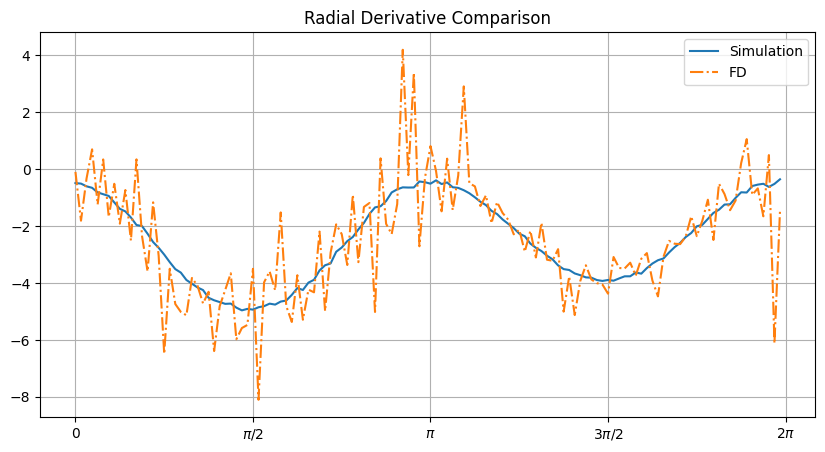

In [13]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
angle = dr.arange(Float, res).numpy() / res * 2 * dr.pi
ax.plot(angle, derSim, label = "Simulation")
ax.plot(angle, derFD, label = "FD", ls = '-.')
ax.legend()
_ = ax.set_xticks([0, dr.pi/2, dr.pi, 3 * dr.pi / 2, 2 * dr.pi])
_ = ax.set_xticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
ax.grid()
ax.set_title("Radial Derivative Comparison")